<a href="https://colab.research.google.com/github/Ryan-howard007/DWH_BASICS/blob/main/Airbnb_Singapore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Analysis on Airbnb listing data of Singapore
# Link : https://insideairbnb.com/get-the-data/

In [2]:
from google.colab import files

upload_file=files.upload()

Saving listings.csv.gz to listings.csv.gz


In [3]:
#Package imports
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import folium  # If folium not installed, can be installed as follows:  pip install folium
from folium.plugins import HeatMap

In [4]:
# File loading and Data Type detection
listings=pd.read_csv('listings.csv.gz',compression='gzip')

#Let's check out all the column types
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
print(listings.dtypes.to_frame('data type').sort_index())
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

#Let's modify columns in the new dataframe, by not indulging with original source
df=listings.copy()

                                             data type
accommodates                                     int64
amenities                                       object
availability_30                                  int64
availability_365                                 int64
availability_60                                  int64
availability_90                                  int64
availability_eoy                                 int64
bathrooms                                      float64
bathrooms_text                                  object
bedrooms                                       float64
beds                                           float64
calculated_host_listings_count                   int64
calculated_host_listings_count_entire_homes      int64
calculated_host_listings_count_private_rooms     int64
calculated_host_listings_count_shared_rooms      int64
calendar_last_scraped                           object
calendar_updated                               float64
descriptio

In [14]:
print(listings.shape)

(3540, 79)


<Axes: xlabel='room_type', ylabel='price'>

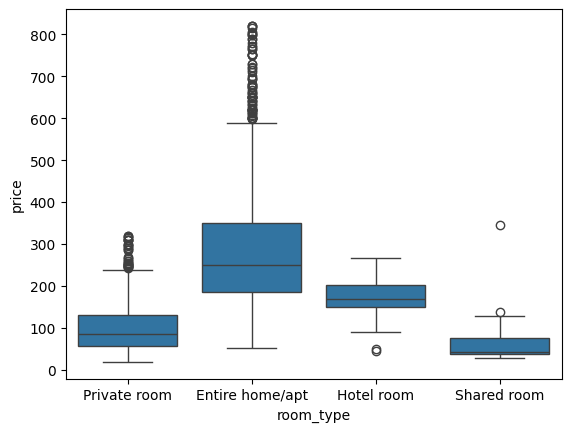

In [5]:
#Drop repetition of rows
df=df.drop_duplicates()

#Modifying the price data type to float from object
df['price']=df['price'].replace(r'[$,]','',regex=True).astype('float')
df=df[df['price']>0] #Valid if price is > 0
df=df[df['accommodates']>0] #Valid if #of accommodates > 0

# Remove outliers of price for each type of room_type
df=df[df['price']<df.groupby('room_type')['price'].transform(lambda x: x.quantile(0.95))]
#Direct comparison of price with groupby+quantile / agg doesn't work ; why? doesn't retrieve back to the Dataframe type post comparison, in such instance it can be achieved by transform

#price_threshold_room_type=df.groupby('room_type')['price'].quantile(0.95).to_dict()
#mask=df.apply(lambda x: x['price'] < price_threshold_room_type[x['room_type']],axis=1)
#df=df[mask]
sns.boxplot(data=df,x='room_type',y='price')

We see high variance (variation) within the Entire home/apt category, despite removing the top 5% of pricing per room type as a anomoly / outlier, would be better to segment it further.

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '_HK'),
  Text(1, 0, '1 BHK'),
  Text(2, 0, '2 BHK'),
  Text(3, 0, '3 BHK'),
  Text(4, 0, '3+ BHK'),
  Text(5, 0, 'Unknown')])

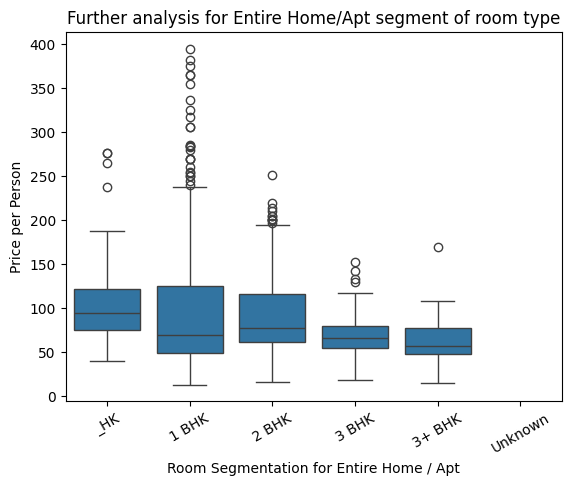

In [6]:
Entire_home_apt=df[df['room_type']=='Entire home/apt'].copy()
Entire_home_apt['price per person']=Entire_home_apt['price']/Entire_home_apt['accommodates']
Entire_home_apt.shape

def bedroom_segmentation(bedrooms):
  try:
    bedrooms=int(float(bedrooms))
    if bedrooms==0:
      return "_HK"
    elif bedrooms==1:
      return "1 BHK"
    elif bedrooms==2:
      return "2 BHK"
    elif bedrooms==3:
      return "3 BHK"
    elif bedrooms>=4:
      return "3+ BHK"
    else:
      return "Unkown "
  except Exception as e:
    return "Error!!"
Entire_home_apt['room segmentation']=Entire_home_apt['bedrooms'].apply(bedroom_segmentation)

#Plotting for Entire Home/Apt room type segment alone
sns.boxplot(data=Entire_home_apt,x='room segmentation',y='price per person',order=['_HK','1 BHK','2 BHK','3 BHK','3+ BHK','Unknown'])
plt.xlabel('Room Segmentation for Entire Home / Apt')
plt.ylabel('Price per Person')
plt.title('Further analysis for Entire Home/Apt segment of room type')
plt.xticks(rotation=30)


Well within the Entire Home/Apt, there's high variance for 0 BHK, 1 BHK followed by 2 BHK , while for the others, there isn't much variation as we see the chart. Maybe there's demand among those 3 of the bedroom segmentations.

([0, 1, 2, 3],
 [Text(0, 0, 'Private room'),
  Text(1, 0, 'Entire home/apt'),
  Text(2, 0, 'Hotel room'),
  Text(3, 0, 'Shared room')])

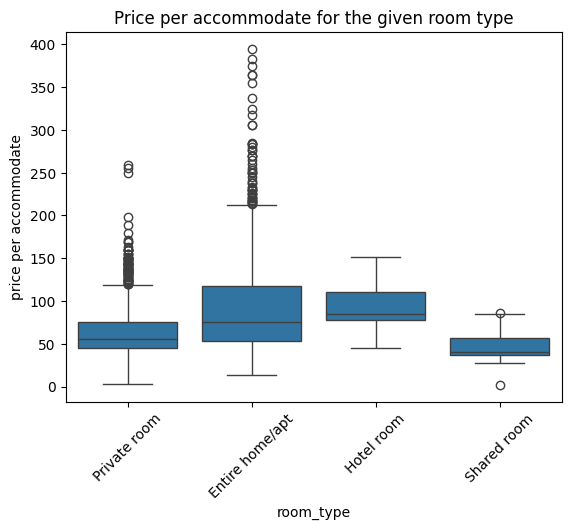

In [7]:
df['price per accommodate']=df['price']/df['accommodates']
sns.boxplot(data=df,y='price per accommodate',x='room_type')
plt.title('Price per accommodate for the given room type')
plt.xticks(rotation=45)

There isn't high difference in pricing compared to the average pricing per room as a whole!

In [8]:
#HeatMap using Folium

valid_location_entry_and_price=df[(df['price']>0) & (df['longitude'].between(-180,180)) & (df['latitude'].between(-90,90))]
mapCentre= (
    valid_location_entry_and_price['latitude'].mean(),
    valid_location_entry_and_price['longitude'].mean()
    )
map=folium.Map(location=mapCentre,zoom_start=12)
heatmap=valid_location_entry_and_price[['latitude','longitude','price']].values.tolist()
HeatMap(heatmap,radius=12,max_zoom=14).add_to(map)
map

Heatmap of areas where there are active Airbnb listings in Singapore.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Marina South'),
  Text(1, 0, 'Orchard'),
  Text(2, 0, 'Southern Islands'),
  Text(3, 0, 'Clementi'),
  Text(4, 0, 'Tanglin'),
  Text(5, 0, 'Central Water Catchment')])

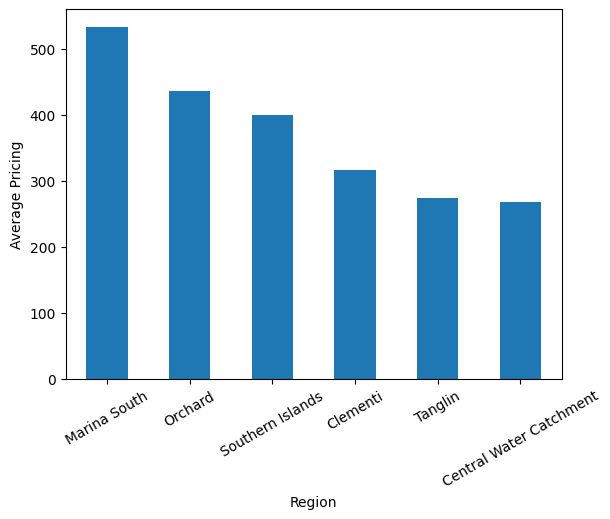

In [13]:
# Average Price per stay
df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(6).plot(kind='bar')
plt.xlabel("Region")
plt.ylabel("Average Pricing")
plt.xticks(rotation=30)

In [10]:
df['estimated_occupancy_l365d'].count()

np.int64(2522)

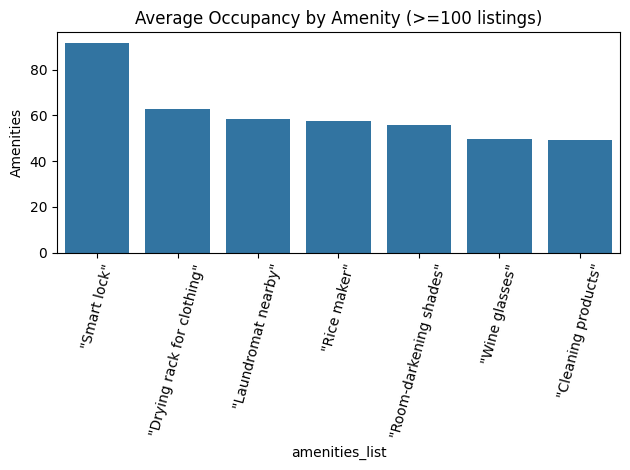

In [16]:
df['amenities_ext']=df['amenities'].str.replace(r'[{\[\]}"]','')
df['amenities_list']=df['amenities_ext'].str.split(',')

# Exploide -> Each value in separate row
amenities_ext=df.explode('amenities_list')
amenities_ext['amenities_list']=amenities_ext['amenities_list'].str.strip()

top_amenities=amenities_ext.groupby('amenities_list')['estimated_occupancy_l365d'].agg(['mean','count']).reset_index()
top_amenities=top_amenities[top_amenities['count']>99]

top_amenities = top_amenities.sort_values('mean', ascending=False).head(7)

sns.barplot(data=top_amenities,x='amenities_list',y='mean')
plt.title("Average Occupancy by Amenity (>=100 listings)")
plt.ylabel("Occupancy Days (Past Year)")
plt.xticks(rotation=75)
plt.ylabel("Amenities")
plt.tight_layout()


Smart Lock is the most preferred room amenity with higher occupancy rate (minimum 100 listings)

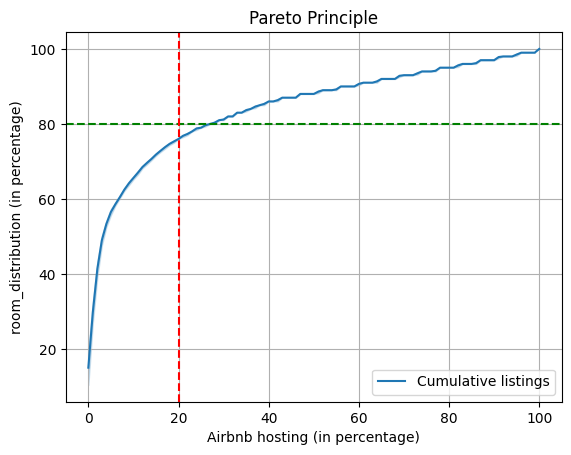

In [17]:
# Pareto Analysis based on host vs room_listings
total_listings=df['host_id'].value_counts().reset_index()
total_listings.columns=['host_id','hosted_room_count']
total_listings=total_listings.sort_values(by='hosted_room_count',ascending=False).reset_index(drop=True)
total_listings['cumulative by room_count']=(total_listings['hosted_room_count'].cumsum()/total_listings['hosted_room_count'].sum()*100).astype(int)
total_listings['pct of host']=range(1,len(total_listings)+1)
total_listings['pct of host']=(total_listings['pct of host']/len(total_listings) * 100).astype(int)

sns.lineplot(data=total_listings,x='pct of host',y='cumulative by room_count',label='Cumulative listings')
plt.xlabel('Airbnb hosting (in percentage)')
plt.ylabel('room_distribution (in percentage)')
plt.title("Pareto Principle")
plt.axhline(80,color='green',linestyle='--')
plt.axvline(20,color='red',linestyle='--')
plt.grid(True)

Between 25% - 30% of hosts dominate 80% of room hosting in Singapore.

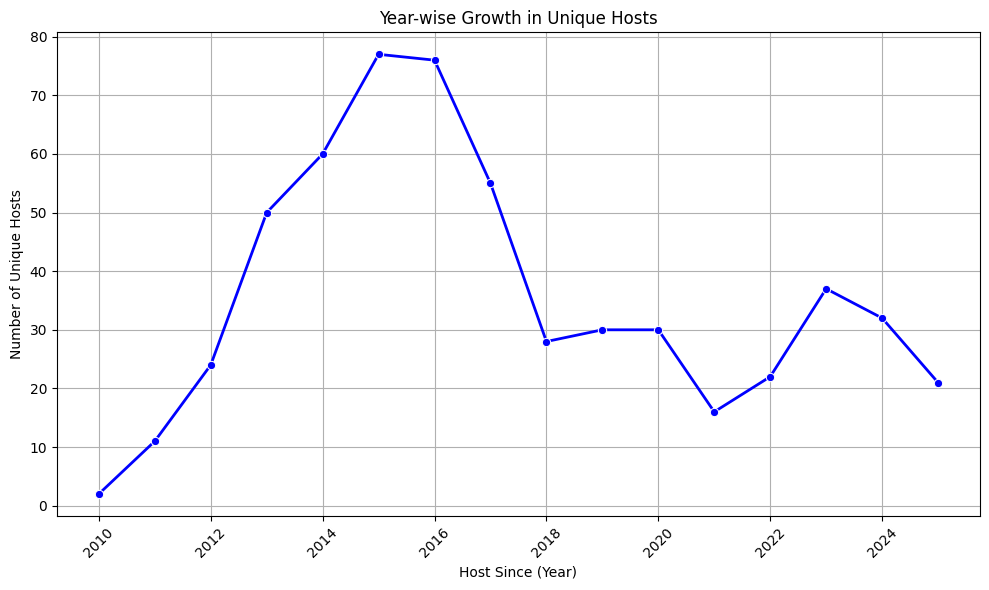

In [18]:
df['host_year']=pd.to_datetime(df['host_since']).dt.year
count=df.groupby('host_year')['host_id'].nunique().reset_index(name='host_count')


# Make sure data is sorted by year
count = count.sort_values(by='host_year')

# Set up the figure and axes
plt.figure(figsize=(10, 6))
# Line plot on top
sns.lineplot(data=count, x='host_year', y='host_count', marker='o', color='blue', linewidth=2)

# Formatting
plt.title('Year-wise Growth in Unique Hosts')
plt.xlabel('Host Since (Year)')
plt.ylabel('Number of Unique Hosts')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The year 2015 saw the highest no: of new hosts.

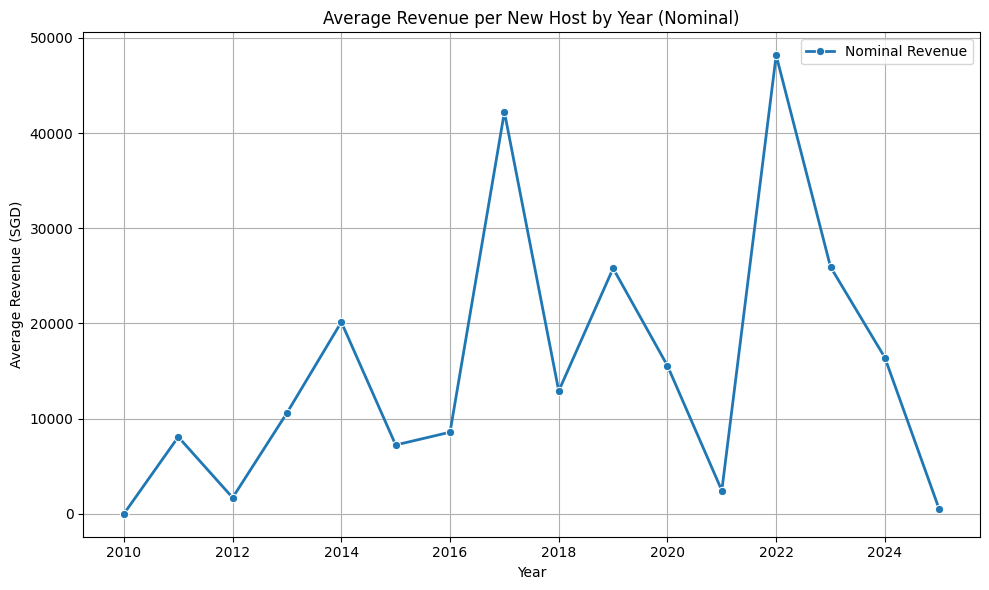

In [25]:
yearly_revenue=df.groupby(['host_year', 'host_id'])['estimated_revenue_l365d'].sum().reset_index()
avg_revenue_per_host = yearly_revenue.groupby('host_year')['estimated_revenue_l365d'].mean().reset_index()
avg_revenue_per_host.columns = ['host_year', 'avg_revenue_per_host']


plt.figure(figsize=(10,6))
sns.lineplot(data=avg_revenue_per_host, x='host_year', y='avg_revenue_per_host', marker='o',linewidth='2', label='Nominal Revenue')
plt.title("Average Revenue per New Host by Year (Nominal)")
plt.ylabel("Average Revenue (SGD)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()


2020 fall in average revenue was due to Covid-19, same trend continued even in the year 2021.The year 2025 has very limited data.